In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

# Hide Warnings
pd.options.mode.chained_assignment = None

# Intelligent Data Analysis Project: Income

By Lucas Hoeft

In [54]:
# Import data set and add column names
income = pd.read_csv('data/einkommen.train', sep=",", na_values = " ?", header=None)

# Set Column Names
columns = ["Age", "Employment Type", "Weighting Factor", "Education Level", "Schooling/Training Period", "Marital Status", "Employment Area", "Partnership", "Ethnicity", "Gender", "Gains", "Losses", "Weekly Working Time", "Country Of Birth", "Income"]
income.columns = columns

# Remove leading/trailing whitespaces from columns that contain strings
string_columms = income.select_dtypes(object).columns
income[string_columms] = income[string_columms].apply(lambda x: x.str.strip())

In [55]:
# Split data set into sets where Income is known or unknwn
income_labeled = income[income['Income'].notnull()]
income_unlabeled = income[income['Income'].isnull()]

## Problem Setting

Task: Predict income (under or over 50k) based on interview answers from 30.000 individuals. The income is known for 5.000 of the 30.000 people. The income needs to be predicted for the other 25.000 people. The data set contains missing values.

---

Input (X): Interview answers of 30.000 individuals

Target (y): Income ("<=50k" or ">50k") known for 5.000 of the 30.000 individuals

Optimization Criterion: Find machine learning model that shows results for predicting the income. The cost of false negative (FN) and false positive (FP) classificiation are equal.

---

Type: Supervised Learning

Concept: Classificiation

Chosen Methods:

* Support Vector Machine (Hinge Loss, L2 Regularizer)

Allows search of hyperplanes in higher dimensions.

* Decision Tree

Decision trees allow a better visualization of the internal behavior which makes it more reasonable.

* Random Forest

Easy to apply and lead most of the time to better results than the decision tree.

## Analysis

### General Overview

In [56]:
print("Number of Rows:", income_labeled.shape[0])
print("Number of Columns (incl. Target):", income_labeled.shape[1])

Number of Rows: 5000
Number of Columns (incl. Target): 15


In [57]:
# Look at input values
income_labeled.head()

,Age,Employment Type,Weighting Factor,Education Level,Schooling/Training Period,Marital Status,Employment Area,Partnership,Ethnicity,Gender,Gains,Losses,Weekly Working Time,Country Of Birth,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Analysis of Numeric Variables

In [58]:
income_labeled.describe()

,Age,Weighting Factor,Schooling/Training Period,Gains,Losses,Weekly Working Time
count,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.600200,1.907684e+05,10.079600,1033.640200,93.696800,40.519000
std,13.594695,1.063596e+05,2.534906,7051.802077,410.801418,12.109193
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176958e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.794750e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.416575e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.033222e+06,16.000000,99999.000000,2547.000000,99.000000


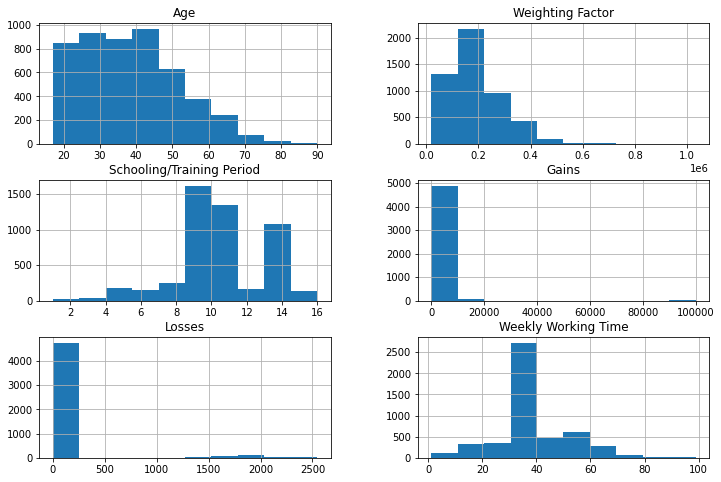

In [59]:
# Check how numeric values are distributed
numeric_distribution = income_labeled.hist(figsize=(12,8))

The boxplots above shows that the numeric variables follow different scales. This indicates that some kind of normalization is needed. Most of them also differ from the normal distribution.

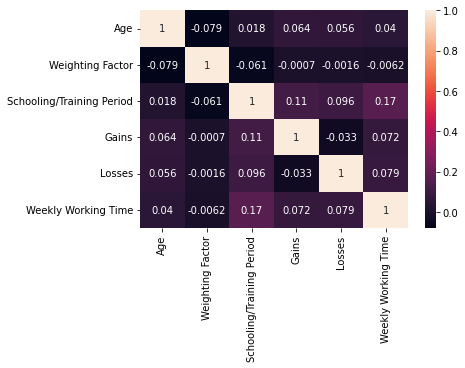

In [60]:
# Correlations between numeric features
correlation_matrix = sns.heatmap(income_labeled.corr(), annot=True)

No strong correlations can be seen between numerical variables.

### Analysis of Categorical Variables

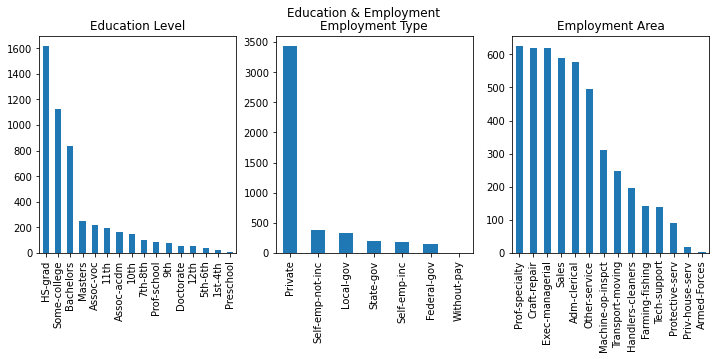

In [61]:
# Education & Employment
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Education & Employment')
income_labeled['Education Level'].value_counts().plot(kind='bar', ax=ax1)
ax1.title.set_text('Education Level')
income_labeled['Employment Type'].value_counts().plot(kind='bar', ax=ax2)
ax2.title.set_text('Employment Type')
income_labeled['Employment Area'].value_counts().plot(kind='bar', ax=ax3)
ax3.title.set_text('Employment Area')
plt.show()

Education level is the only categorical variable with an order. In employment type most people work in the private sector which could result in little usefulness of this variable.

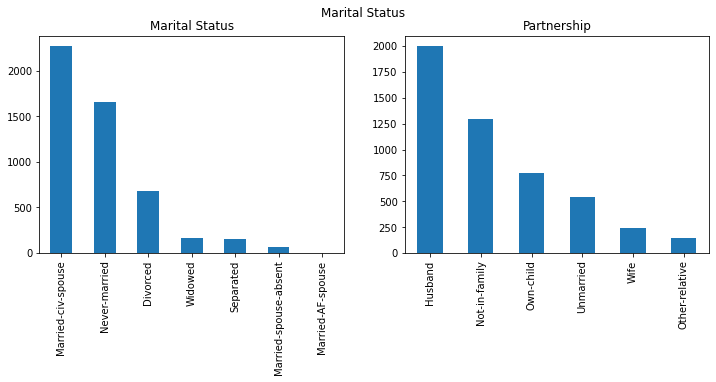

In [62]:
# Marital Status
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Marital Status')
income_labeled['Marital Status'].value_counts().plot(kind='bar', ax=ax1)
ax1.title.set_text('Marital Status')
income_labeled['Partnership'].value_counts().plot(kind='bar', ax=ax2)
ax2.title.set_text('Partnership')
plt.show()

The variable 'Partnership' describes the relationship of the person.

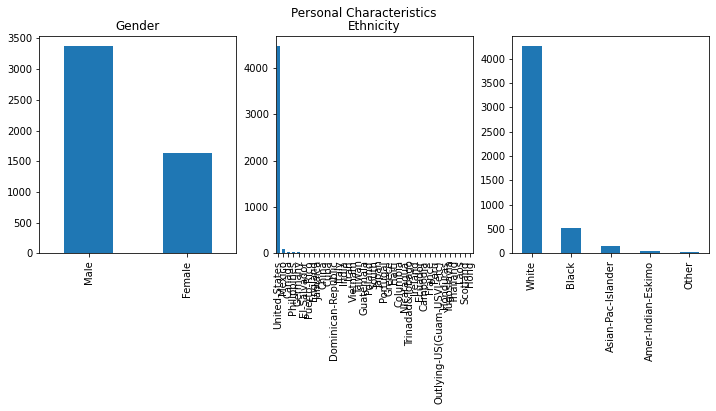

In [63]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Personal Characteristics')
income_labeled['Gender'].value_counts().plot(kind='bar', ax=ax1)
ax1.title.set_text('Gender')
income_labeled['Country Of Birth'].value_counts().plot(kind='bar', ax=ax2)
ax2.title.set_text('Country Of Birth')
income_labeled['Ethnicity'].value_counts().plot(kind='bar', ax=ax3)
ax2.title.set_text('Ethnicity')
plt.show()

Male individuals are overrepresented. Most of the individuals were born in the US decresing the meaningfulness of this variable. White people shows the highest representation in this data set. These three variables are the most questioning varibales based on ethics.

In [64]:
# Top 5 Origin Countries
income_labeled.groupby(['Country Of Birth'])['Country Of Birth'].count().sort_values(ascending=False).head(5)

Country Of Birth
United-States    4465
Mexico            104
Canada             28
Philippines        22
Germany            22
Name: Country Of Birth, dtype: int64

Nearly all of the interviewed people are from the US (majority class) and all other countries are minority classes. This indicates a low relevance of this feature and bad predictions for people from the minority class countries if we would assume that this feature is a relevant feature for predicting the income.

Income
<=50K    3779
>50K     1221
Name: Income, dtype: int64

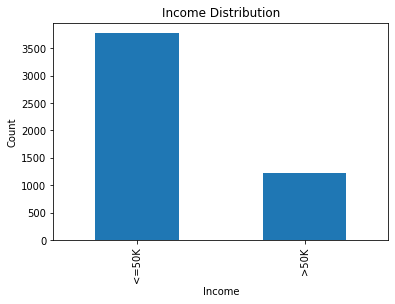

In [65]:
# Check balance of target variable
target_distribution = income_labeled['Income'].value_counts().plot(kind='bar')
target_distribution.set(xlabel="Income", ylabel="Count", title="Income Distribution")

income_labeled.groupby(['Income'])['Income'].count()

The target variable is imbalanced because "<= 50K" occurs three times as often as ">50k". Though, the imbalance is only mild as the proportion of the minority class is between 20-40% [1]. If accuracy would be chosen as the evaluation metric, the baseline would be at 0,76 which means classifying everyone as "<= 50K". Due to the imbalanced classes, precision and recall (with f-measure) should be selected over accuracy as the evaluating metric.

### Analysis of Missing Values

In [66]:
print("Number of Rows with NA Values:", income_labeled.isnull().any(axis=1).sum())
print("Fraction of Rows with NA Values", round(income_labeled.isnull().any(axis=1).sum()/income_labeled.shape[0]*100, 2), "%")

income_labeled.isna().sum()

Number of Rows with NA Values: 420
Fraction of Rows with NA Values 8.4 %


Age                            0
Employment Type              331
Weighting Factor               0
Education Level                0
Schooling/Training Period      0
Marital Status                 0
Employment Area              331
Partnership                    0
Ethnicity                      0
Gender                         0
Gains                          0
Losses                         0
Weekly Working Time            0
Country Of Birth              97
Income                         0
dtype: int64

Missing values appear in three columns which are all categorical variables.

## Data Preparation

In [67]:
# Remove irrelevant/unused column
# Weighting factor - to compensate for an interview-dependent selection bias
income_labeled = income_labeled.drop('Weighting Factor', axis=1)

The meaningfulness of this feature is questionable. No calculations were done to 'compensate the interview-dependent selection bias'. Therefore this feature is removed. During exploration 
The characteristic showed low explanatory power of income when explored.

In [68]:
# Handling Missing Values
income_labeled = income_labeled.dropna()

The missing values were only in categorical. The instances (rows) were removed.

In [69]:
from sklearn.preprocessing import OrdinalEncoder

# Ordinal Encoding for Education Level (ordinal)
education_level = ['Preschool','1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors', 'Masters', 'Doctorate']
oe_edu = OrdinalEncoder(categories=[education_level])
income_labeled['Education Level'] = oe_edu.fit_transform(income_labeled[['Education Level']])

As the education level has an internal order, the variable was transformed into numeric order.

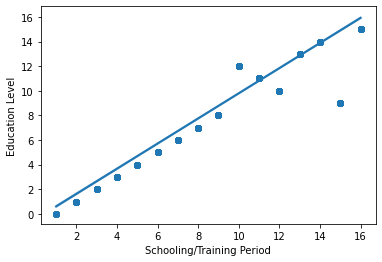

,Education Level,Schooling/Training Period,Income
Education Level,1.000000,0.870818,0.229661
Schooling/Training Period,0.870818,1.000000,0.315673
Income,0.229661,0.315673,1.000000


In [70]:
# Correlation between 'Schooling/Training Period' and 'Education Level'
regression_plot = sns.regplot(x='Schooling/Training Period', y='Education Level', data=income_labeled)
plt.show()

education_correlation = income_labeled.copy()
education_correlation['Income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)

education_correlation[['Education Level', 'Schooling/Training Period', 'Income']].corr()

The feature 'Education Level' (e.g. High School, Bachelor, Master) shows a strong correlation with the feature 'Schooling/Training Period'. Only for higher education levels that allow more flexiblity the linearity between the two features ends. The feature 'Schooling/Training Period' shows a stronger correlation with the target variable 'Income' than the feature 'Education Level'.

In [71]:
# One-Hot Encoding for categorical variables (without order)
one_hot_columns = ['Employment Type', 'Marital Status', 'Employment Area', 'Partnership', 'Ethnicity', 'Gender', 'Country Of Birth']
income_labeled = pd.get_dummies(income_labeled, columns=one_hot_columns)

In [72]:
# Transform Target Variable to Numeric
income_labeled['Income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)
labels = ['<=50K', '>50K']

In [73]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling: MinMaxScaling (intervall 0, 1)
income_labeled_scaled = income_labeled.copy()

col_names = ['Age', 'Education Level', 'Schooling/Training Period', 'Weekly Working Time', 'Gains', 'Losses']
features = income_labeled_scaled[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
income_labeled_scaled[col_names] = features

For better performance for finding and training the models and balancing the importance between the variables, the numeric variables were scaled to an interval of 0 and 1.

In [80]:
from sklearn.model_selection import train_test_split

# Train / Test-Split
income_X_train, income_X_test, income_y_train, income_y_test = train_test_split(income_labeled_scaled.drop('Income', axis=1), income_labeled['Income'], test_size=0.25, random_state=42)

# Dimensions of the data set after split
print("Data Sets after Data Preparation/Preprocessing:\n")
print("Number of Rows:", income_labeled.shape[0])
print("Number of Columns (incl. Target):", income_labeled.shape[1])

print("\nTrain Data Set")
print("Number of Rows:", income_X_train.shape[0])
print("Number of Columns (excl. Target):", income_X_train.shape[1])

print("\nTest Data Set")
print("Number of Rows:", income_X_test.shape[0])
print("Number of Columns (excl. Target):", income_X_test.shape[1])

Data Sets after Data Preparation/Preprocessing:

Number of Rows: 4580
Number of Columns (incl. Target): 87

Train Data Set
Number of Rows: 3435
Number of Columns (excl. Target): 86

Test Data Set
Number of Rows: 1145
Number of Columns (excl. Target): 86


## Methods

### Linear Classification

In [23]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning
parameters = {'kernel': ('linear', 'rbf'), 'gamma': [0.001, 0.01, 0.1, 1], 'C': [0.1, 1, 10, 100]}
svc = svm.SVC()
clf_svm = GridSearchCV(svc, parameters, scoring='f1', verbose=2, n_jobs=-1)
clf_svm.fit(income_X_train, income_y_train)
print(clf_svm)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ('linear', 'rbf')},
             scoring='f1', verbose=2)


With cross-validation the best hyperparameters (kernel = kernel type, gamma = kernel coefficient, C = regularizer) were chosen for the support vector machine based on the given parameters. The scoring was set to f-measure to balance precision and recall.

In [24]:
clf_svm_best = clf_svm.best_estimator_
print(clf_svm_best)

# Predict
income_y_pred_svm = clf_svm_best.predict(income_X_test)

SVC(C=100, gamma=0.001, kernel='linear')

### Decision Tree

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn import tree

# Hyperparameter Tuning
parameters = {'max_depth': np.arange(2,10), 'min_samples_leaf': [2, 5, 10, 20, 50, 100]}
dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_dt = GridSearchCV(dtc, parameters, scoring='f1', verbose=2, n_jobs=-1)
clf_dt.fit(income_X_train, income_y_train)
print(clf_dt)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': [2, 5, 10, 20, 50, 100]},
             scoring='f1', verbose=2)


With cross-validation the best hyperparameters (max_depth = max depth of the decision tree, min_samples_leaf = minimal number of samples in a leaf node) were chosen for the decision tree based on the given parameters. The split criterion was set to entropy. The scoring was set to f-measure to balance precision and recall.

In [27]:
clf_dt_best = clf_dt.best_estimator_
print(clf_dt_best)

# Predict
income_y_pred_dt = clf_dt_best.predict(income_X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       random_state=42)

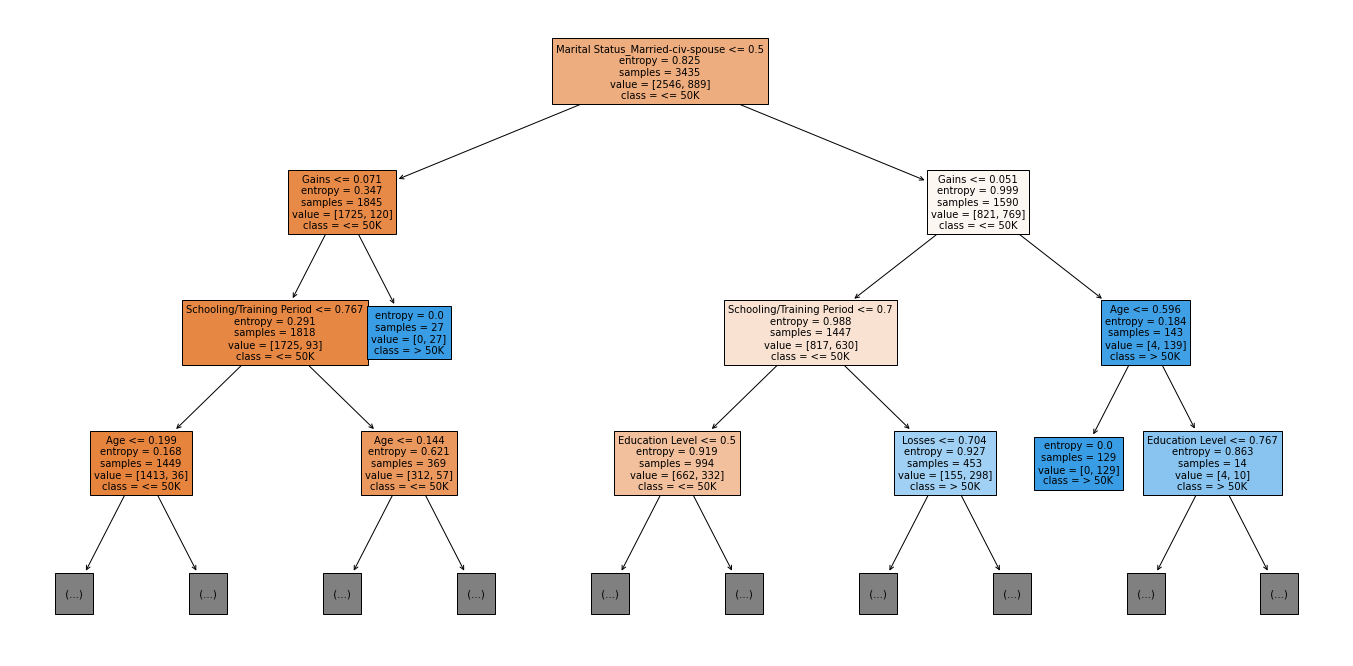

In [85]:
# Visualize Decision Tree
plt.figure(figsize=(24,12))

# Add classnames later again
tree.plot_tree(clf_dt_best, max_depth=3, fontsize=10, feature_names=income_X_train.columns, class_names=["<= 50K", "> 50K"], filled=True)
plt.show()

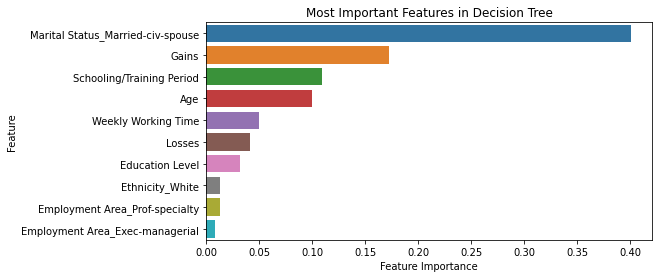

In [30]:
feature_importance_dt = pd.Series(clf_dt_best.feature_importances_,index=income_X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
features_barplot = sns.barplot(x=feature_importance_dt, y=feature_importance_dt.index)
features_barplot.set(xlabel="Feature Importance", ylabel="Feature", title="Most Important Features in Decision Tree")
plt.show()

### Random Forest

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tuning
parameters = {'n_estimators': [100, 200, 500], 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18]}
rfc = RandomForestClassifier(criterion='entropy', random_state=42)
clf_rf = GridSearchCV(rfc, parameters, scoring='f1', verbose=2, n_jobs=-1)
clf_rf.fit(income_X_train, income_y_train)
print(clf_rf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'n_estimators': [100, 200, 500]},
             scoring='f1', verbose=2)


With cross-validation the best hyperparameters (n_estimators = number of trees in the forest, max_depth =  max depth of the decision tree) were chosen for the random forest based on the given parameters. The split criterion was set to entropy. The scoring was set to f-measure to balance precision and recall.

In [ ]:
clf_rf_best = clf_rf.best_estimator_
print(clf_rf_best)

# Predict
income_y_pred_rf = clf_rf_best.predict(income_X_test)

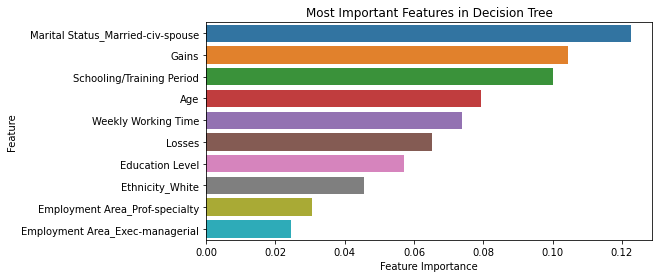

In [34]:
feature_importance_rf = pd.Series(clf_rf.best_estimator_.feature_importances_,index=income_X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
features_barplot = sns.barplot(x=feature_importance_rf, y=feature_importance_dt.index)
features_barplot.set(xlabel="Feature Importance", ylabel="Feature", title="Most Important Features in Decision Tree")
plt.show()

### Model Evaluation

In [90]:
from sklearn.metrics import accuracy_score

# Accuracy
print("Accuracy SVM:", round(accuracy_score(income_y_test, income_y_pred_svm), 4))
print("Accuracy Decision Tree:", round(accuracy_score(income_y_test, income_y_pred_dt), 4))
print("Accuracy Random Forest:", round(accuracy_score(income_y_test, income_y_pred_rf), 4))

Accuracy SVM: 0.8393
Accuracy Decision Tree: 0.8105
Accuracy Random Forest: 0.8498


Only judged by accuracy the random forest perfomed the best followed by SVM and decision tree. This metric should be seen critically as the class was imbalanced and therefore accuracy could be misleading. All models perform better than the baseline (a classifier that classifies everything as "<=50k" with an accuracy of around 0.75.

In [87]:
from sklearn.metrics import classification_report

# Precision, Recall + F-Measure
print("Classification Report (SVM):\n", classification_report(income_y_test, income_y_pred_svm))
print("\nClassification Report (Decision Tree):\n", classification_report(income_y_test, income_y_pred_dt))
print("\nClassification Report (Random Forest):\n", classification_report(income_y_test, income_y_pred_rf))

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       876
           1       0.66      0.65      0.65       269

    accuracy                           0.84      1145
   macro avg       0.78      0.77      0.77      1145
weighted avg       0.84      0.84      0.84      1145


Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       876
           1       0.59      0.62      0.60       269

    accuracy                           0.81      1145
   macro avg       0.74      0.74      0.74      1145
weighted avg       0.81      0.81      0.81      1145


Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       876
           1       0.71      0.61      0.65       269

    accuracy                           0.85      1145
   macro avg    

The f-measure indicates equally good performance of SVM and random forest. The decision tree performs slightly worse.

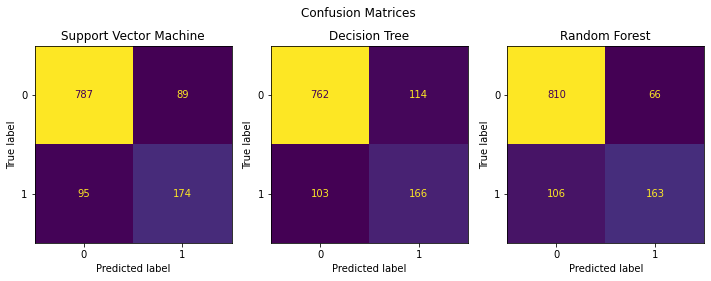

In [88]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Confusion Matrices')
ConfusionMatrixDisplay.from_predictions(income_y_test, income_y_pred_svm, ax=ax1, colorbar=False)
ax1.title.set_text('Support Vector Machine')
ConfusionMatrixDisplay.from_predictions(income_y_test, income_y_pred_dt, ax=ax2, colorbar=False)
ax2.title.set_text('Decision Tree')
ConfusionMatrixDisplay.from_predictions(income_y_test, income_y_pred_rf, ax=ax3, colorbar=False)
ax3.title.set_text('Random Forest')
plt.show()

The confusion matrices give more insights about missclassifications which can be influenced by the imbalanced target variable.

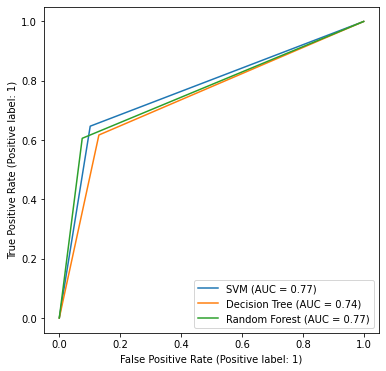

In [89]:
# ROC/AUC
from sklearn.metrics import RocCurveDisplay

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
RocCurveDisplay.from_predictions(income_y_test, income_y_pred_svm, name="SVM", ax=ax)
RocCurveDisplay.from_predictions(income_y_test, income_y_pred_dt, name="Decision Tree", ax=ax)
RocCurveDisplay.from_predictions(income_y_test, income_y_pred_rf, name="Random Forest", ax=ax)
plt.show()

All three methods show similiar results for the ROC curve and AUC (area under curve). Based on this metric, SVM and Random Forest perform the best.

## Prediction

In [91]:
# Apply same transformations applied to income_labeled
income_unlabeled_transformed = income_unlabeled.copy()

income_unlabeled_transformed = income_unlabeled_transformed.drop('Weighting Factor', axis=1)
income_unlabeled_transformed = income_unlabeled_transformed.drop('Income', axis=1)
income_unlabeled_transformed = income_unlabeled_transformed.dropna()
income_unlabeled_transformed['Education Level'] = oe_edu.fit_transform(income_unlabeled_transformed[['Education Level']])
income_unlabeled_transformed = pd.get_dummies(income_unlabeled_transformed, columns=one_hot_columns)

# Apply the same scaler for predicting based on the fit of the train data
col_names = ['Age', 'Education Level', 'Schooling/Training Period', 'Weekly Working Time', 'Gains', 'Losses']
features = income_unlabeled_transformed[col_names]
features = scaler.transform(features.values)
income_unlabeled_transformed[col_names] = features

# Filter by columns that were used for training the model
income_unlabeled_X = income_unlabeled_transformed[income_X_train.columns.to_list()]

# Predict labels with the random forest
income_unlabeled_y_pred = clf_rf_best.predict(income_unlabeled_X)

# Merge together
income_unlabled_predicted = income_unlabeled_X
income_unlabled_predicted['Income'] = income_unlabeled_y_pred.tolist()
income_unlabled_predicted['Income'].replace([0, 1], ['<=50K', '>50K'], inplace=True)

display(income_unlabled_predicted)

print("Predictions for the 25.000 people of whom the income was unknown:")
income_unlabled_predicted.groupby(['Income'])['Income'].count()

,Age,Education Level,Schooling/Training Period,Gains,Losses,Weekly Working Time,Employment Type_Federal-gov,Employment Type_Local-gov,Employment Type_Private,Employment Type_Self-emp-inc,...,Country Of Birth_Puerto-Rico,Country Of Birth_Scotland,Country Of Birth_South,Country Of Birth_Taiwan,Country Of Birth_Thailand,Country Of Birth_Trinadad&Tobago,Country Of Birth_United-States,Country Of Birth_Vietnam,Country Of Birth_Yugoslavia,Income
5000,0.410959,0.600000,0.933333,0.278283,0.000000,0.500000,0,0,0,1,...,0,0,0,0,0,0,1,0,0,>50K
5001,0.520548,0.866667,0.800000,0.000000,0.624264,0.377551,0,0,1,0,...,0,0,0,0,0,0,1,0,0,<=50K
5002,0.123288,0.533333,0.533333,0.050131,0.000000,0.397959,0,0,1,0,...,0,0,0,0,0,0,1,0,0,<=50K
5003,0.150685,0.533333,0.533333,0.000000,0.000000,0.397959,0,0,1,0,...,0,0,0,0,0,0,1,0,0,<=50K
5004,0.260274,0.533333,0.533333,0.000000,0.000000,0.397959,0,0,1,0,...,0,0,0,0,0,0,1,0,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.178082,0.933333,0.866667,0.000000,0.000000,0.448980,0,0,1,0,...,0,0,0,0,0,0,0,0,0,<=50K
29996,0.424658,0.733333,0.666667,0.000000,0.000000,0.561224,0,0,1,0,...,0,0,0,0,0,0,0,0,0,<=50K
29997,0.602740,0.800000,0.600000,0.000000,0.000000,0.346939,0,1,0,0,...,0,0,0,0,0,0,1,0,0,<=50K
29998,0.328767,0.533333,0.533333,0.000000,0.000000,0.397959,0,0,1,0,...,0,0,0,0,0,0,1,0,0,<=50K


Predictions for the 25.000 people of whom the income was unknown:


Income
<=50K    18755
>50K      4469
Name: Income, dtype: int64

## Conclusion

The different models showed similiar results based on the checked metrics (F-Measure and ROC AUC). The random forest slightly outperforms the other models.

For the future:
* Balance the data set for target variable (e.g. with downsampling)
* Test binning or removing of heavily skewed/imbalanced variables (e.g. gains, losses, country of birth)
* Extent hyperparameter search trying out more combinations (e.g. with <code>RandomizedSearchCV</code>)
* Check if decision trees / random forest perform better without one-hot encoding

## References

[1] Imbalanced Data by Google Developers: https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data